## Sentiment Analysis of Amazon Review Data

In [151]:
import json
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, f_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [152]:
with open('config.json') as json_data_file:
    config = json.load(json_data_file)

In [153]:
data = pd.read_csv("./Data_filtered/reviews_Automotive.csv", sep=";")
data.head(5)

,review,rating,product
0,"['needed', 'set', 'jumper', 'cables', 'new', '...",5.0,B00002243X
1,"['long', 'cables', 'work', 'fine', 'truck', 'q...",4.0,B00002243X
2,"['comment', 'much', 'since', 'yet', 'used', 'c...",5.0,B00002243X
3,"['absolutley', 'love', 'amazon', 'price', 'set...",5.0,B00002243X
4,"['purchased', 'twelve', 'feet', 'long', 'cable...",5.0,B00002243X


In [154]:
# 1, 2, 3 = negativ 4, 5 = positiv
data["label"] = pd.cut(data["rating"], bins = config["label_two"]["bins"], labels = config["label_two"]["labels"])
data["label"] = data["label"].astype(str)
data.head(5)

,review,rating,product,label
0,"['needed', 'set', 'jumper', 'cables', 'new', '...",5.0,B00002243X,positiv
1,"['long', 'cables', 'work', 'fine', 'truck', 'q...",4.0,B00002243X,positiv
2,"['comment', 'much', 'since', 'yet', 'used', 'c...",5.0,B00002243X,positiv
3,"['absolutley', 'love', 'amazon', 'price', 'set...",5.0,B00002243X,positiv
4,"['purchased', 'twelve', 'feet', 'long', 'cable...",5.0,B00002243X,positiv


In [155]:
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['label'], test_size=0.2, random_state=42, stratify=data['label'])

#Vectorizer
vect = CountVectorizer()
#vect = TfidfVectorizer()

#feature selection
f_select = SelectKBest(f_classif, k=10000)
f_select = SelectPercentile(f_classif, percentile=20)

from sklearn.ensemble import RandomForestClassifier

#Classifier
#clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)
#clf = LinearSVC(C=1.0, penalty= "l1", max_iter=3000, dual=False)
clf = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=42)
#clf = LogisticRegression(random_state=42, class_weight=None, max_iter=3000)



#Building the Pipeline
pipeline = Pipeline([('vect', vect),
                     ('f_select', f_select), 
                     ('clf', clf)])

In [156]:
from sklearn import metrics
model = pipeline.fit(X_train, y_train)

#Results step of Pipeline
vectorizer = model.named_steps['vect']
feature_selection = model.named_steps['f_select']
classifier = model.named_steps['clf']


#Accuracy score of Train Data
print("accuracy score: " + str(model.score(X_train, y_train)))

accuracy score: 0.8740994016363415


In [157]:
from sklearn.metrics import accuracy_score
model = pipeline.fit(X_train, y_train)

#Accuracy Score of Model prediction 
print("accuracy score: " + str(model.score(X_test, y_test)))

#Report on prediction of model
predictions = model.predict(X_test)
print("Classificaton Report:")
print(metrics.classification_report(y_true=y_test, y_pred=predictions))

accuracy score: 0.873992673992674
Classificaton Report:
              precision    recall  f1-score   support

     negativ       0.00      0.00      0.00       516
     positiv       0.87      1.00      0.93      3579

   micro avg       0.87      0.87      0.87      4095
   macro avg       0.44      0.50      0.47      4095
weighted avg       0.76      0.87      0.82      4095



C:\Users\Vitalstuttgarter\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Vitalstuttgarter\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Vitalstuttgarter\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [158]:
#Test with Manual review Text
print(model.predict(['My thing broke, very bad']))
print(model.predict(['My order broke and I am very disappointed']))
print(model.predict(['My order works perfect and and I am very glad I bought it']))

['positiv']
['positiv']
['positiv']


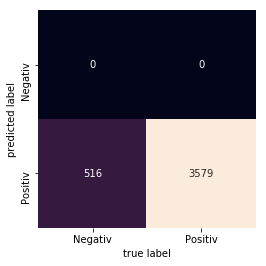

In [159]:
#Confusion matrix of model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = model.predict(X_test)
target_names = ['Negativ', 'Positiv']
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [160]:
from sklearn.model_selection import cross_val_score,  KFold

#kfold
kfold = KFold(n_splits=5)

#StratifiedKFold
#standard for cv=INT is stratified k-fold

scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores))
print("Mean accuracy: {}".format(scores.mean()))

Cross-validation scores: [0.87397009 0.87393162 0.87419847 0.87419847 0.87419847]
Mean accuracy: 0.8740994276755341


In [161]:
from sklearn.model_selection import cross_validate
res = cross_validate(pipeline, X_train, y_train, cv=5, return_train_score=True)

#make DataFrame of result for better Visualisation
res_df = pd.DataFrame(res)
display(res_df)

#Print Mean of all Scores
print("Mean times and scores:\n", res_df.mean())

,fit_time,score_time,test_score,train_score
0,2.846407,0.590400,0.873970,0.874132
1,3.259351,0.605317,0.873932,0.874141
2,3.882621,0.861696,0.874198,0.874075
3,3.138578,0.929549,0.874198,0.874075
4,3.355119,0.655132,0.874198,0.874075


Mean times and scores:
 fit_time       3.296415
score_time     0.728419
test_score     0.874099
train_score    0.874099
dtype: float64


### Untersuchung der Predictions

In [162]:
# Erstellung eines DataFrames mit den Spalten: X_test, y_test, prediction
predictions = model.predict(X_test)
df_prediction = pd.DataFrame({
    'X_test': X_test,
    'y_test': y_test,
    'prediction': predictions
})

# neue Spalte, die Values von Spalten y_test und prediction vergleicht
df_prediction['vergleich'] = df_prediction['y_test'] == df_prediction['prediction']

df_prediction.head()

,X_test,y_test,prediction,vergleich
15806,"['tire', 'gauges', 'kind', 'thing', 'makes', '...",positiv,positiv,True
541,"['like', 'said', 'title', 'review', 'say', 'pr...",positiv,positiv,True
1724,"['comfortable', 'product', 'eliminate', 'stubb...",positiv,positiv,True
3586,"['must', 'tool', 'people', 'work', 'cars', 'se...",positiv,positiv,True
15830,"['purchased', 'joe', 'racing', 'pressure', 'ga...",positiv,positiv,True


In [163]:
# Speichern der Zeilen mit unterschiedlichen Werten in den Spalten "y_test" und "prediction" in einem neuen DF
df_false_predictions = df_prediction[df_prediction.vergleich == False]

df_false_predictions.head()

,X_test,y_test,prediction,vergleich
15707,"['regulator', 'well', 'made', 'leak', 'job', '...",negativ,positiv,False
4998,"['sleek', 'easy', 'mount', 'note', 'middle', '...",negativ,positiv,False
16996,"['used', 'limited', 'fashion', 'preping', 'thi...",negativ,positiv,False
11443,"['like', 'reviewers', 'found', 'blade', 'wipes...",negativ,positiv,False
10258,"['thought', 'would', 'good', 'tool', 'cleaning...",negativ,positiv,False


In [164]:
# Erstellung einer CSV Datei mit den falsch predicteden Zeilen
df_false_predictions.to_csv("false_predictions.csv", sep=';',index=False)